In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import Pool
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [194]:
train = pd.read_csv('open/train.csv')
test = pd.read_csv('open/test.csv')
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [195]:
# occyp_type 빈 공간 N으로 일단 채우기
train['occyp_type'].fillna("N", inplace=True)
test['occyp_type'].fillna("N", inplace=True)
print('null 개수: ', train.isnull().sum().sum())

null 개수:  0


# 종속변수(credit)

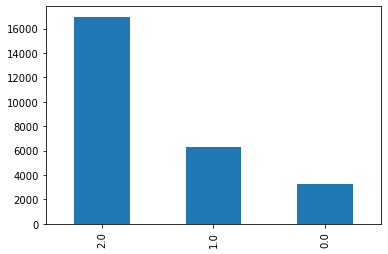

In [177]:
train['credit'].value_counts().plot(kind = 'bar')
plt.show()

# 수치형 변수

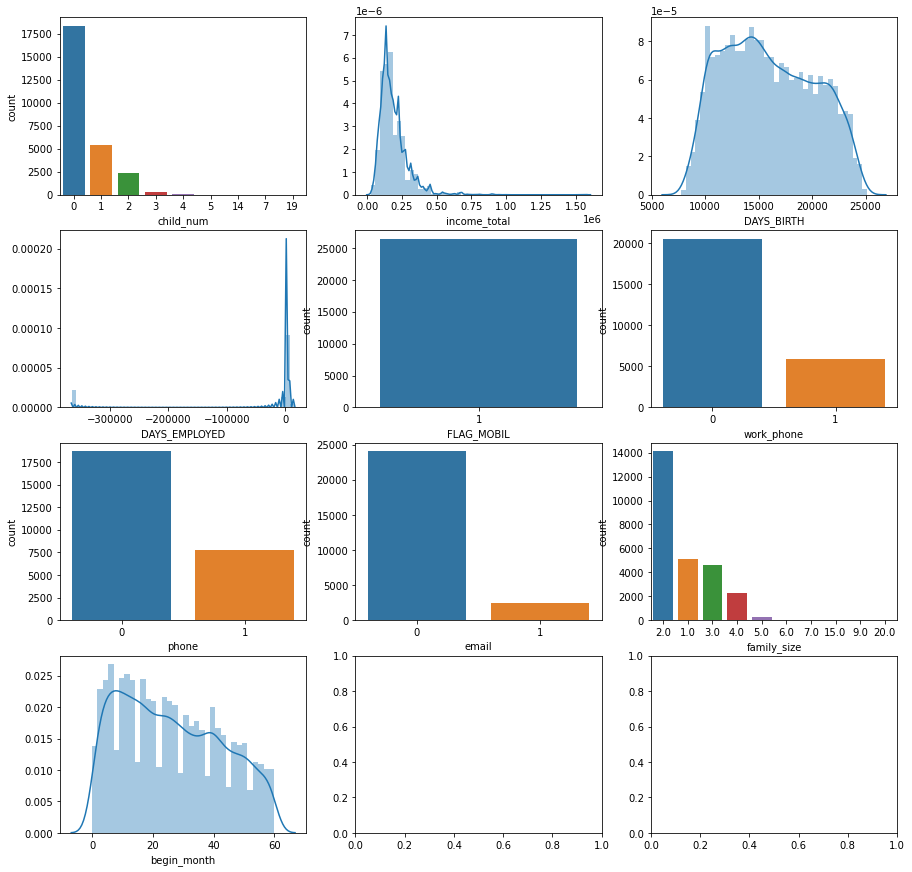

In [178]:
fig, axes = plt.subplots(4,3, figsize = (15,15))
sns.countplot(ax = axes[0,0], x = train['child_num'], order = train['child_num'].value_counts().index)
sns.distplot(train['income_total'], ax = axes[0,1])
sns.distplot(-train['DAYS_BIRTH'], ax = axes[0,2])
sns.distplot(-train['DAYS_EMPLOYED'], ax = axes[1,0])
sns.countplot(ax = axes[1,1], x = train['FLAG_MOBIL'], order = train['FLAG_MOBIL'].value_counts().index)
sns.countplot(ax = axes[1,2], x = train['work_phone'], order = train['work_phone'].value_counts().index)
sns.countplot(ax = axes[2,0], x = train['phone'], order = train['phone'].value_counts().index)
sns.countplot(ax = axes[2,1], x = train['email'], order = train['email'].value_counts().index)
sns.countplot(ax = axes[2,2], x = train['family_size'], order = train['family_size'].value_counts().index)
sns.distplot(-train['begin_month'], ax = axes[3,0])

In [196]:
# flag 모든 값이 동일
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)

In [197]:
# DAYS_EMPLOYED 가 양수인 데이터들이 있다. = 같은날.
print('EMPLOYED 양수 데이터 개수:')
print(train['DAYS_EMPLOYED'][train['DAYS_EMPLOYED'] > 0].value_counts(), '\n')

# 값 0으로 바꾸기
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

EMPLOYED 양수 데이터 개수:
365243    4438
Name: DAYS_EMPLOYED, dtype: int64 



In [198]:
# 만 나이
train.DAYS_BIRTH = round(train.DAYS_BIRTH*(-1)/365,1)

# 근무 개월
train.DAYS_EMPLOYED = round(train.DAYS_EMPLOYED*(-1)/30,1)

# begin_month
train['begin_month'] = np.abs(train['begin_month'])

In [199]:
# child_num, family_size 이상치 제거
train = train[train['family_size'] <= 7]
train = train.reset_index(drop = True)

In [200]:
# 중복된 값들이 많아서 날리기
train = train.drop_duplicates()

## family_size = child_num + (family_type) 라고 추론

In [184]:
family = train[['child_num', 'family_type', 'family_size', 'credit']]

print(len(family[family['family_type'] == 'Married'][family['child_num'] + 2 != family['family_size']]))
print(len(family[family['family_type'] == 'Civil marriage'][family['child_num'] + 2 != family['family_size']]))
print(len(family[family['family_type'] == 'Single / not married'][family['child_num'] + 1 != family['family_size']]))
print(len(family[family['family_type'] == 'Separated'][family['child_num'] + 1 != family['family_size']]))
print(len(family[family['family_type'] == 'Widow'][family['child_num'] + 1 != family['family_size']]))

3
1
18
0
0


<ipython-input-184-500bb11f2cba>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(family[family['family_type'] == 'Married'][family['child_num'] + 2 != family['family_size']]))
<ipython-input-184-500bb11f2cba>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(family[family['family_type'] == 'Civil marriage'][family['child_num'] + 2 != family['family_size']]))
<ipython-input-184-500bb11f2cba>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(family[family['family_type'] == 'Single / not married'][family['child_num'] + 1 != family['family_size']]))
<ipython-input-184-500bb11f2cba>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(family[family['family_type'] == 'Separated'][family['child_num'] + 1 != family['family_size']]))
<ipython-input-184-500bb11f2cba>:7: UserWarning: Boolean Series key will be reindexed to match DataFra

In [185]:
train['family_type'].unique()

array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [186]:
family = train[['child_num', 'family_type', 'family_size', 'credit']]
family_type = train['family_type'].unique()

for i in range(1,8):
    print('family size = ', i)
    f = family[family['family_size'] == i]
    for j in family_type:
        ff = f[f['family_type'] == j]
        if (not(ff.empty)):
            print('\tfamily type = ', j, ' 일 때 : ', ff['credit'].mean())
    

family size =  1
	family type =  Married  일 때 :  2.0
	family type =  Civil marriage  일 때 :  2.0
	family type =  Separated  일 때 :  1.5373406193078325
	family type =  Single / not married  일 때 :  1.4958011420893518
	family type =  Widow  일 때 :  1.496116504854369
family size =  2
	family type =  Married  일 때 :  1.5305207981061888
	family type =  Civil marriage  일 때 :  1.493915533285612
	family type =  Separated  일 때 :  1.4782608695652173
	family type =  Single / not married  일 때 :  1.5267857142857142
	family type =  Widow  일 때 :  1.6153846153846154
family size =  3
	family type =  Married  일 때 :  1.5148213833291106
	family type =  Civil marriage  일 때 :  1.4085257548845471
	family type =  Separated  일 때 :  1.4918032786885247
	family type =  Single / not married  일 때 :  1.5714285714285714
	family type =  Widow  일 때 :  1.0
family size =  4
	family type =  Married  일 때 :  1.5471066475370636
	family type =  Civil marriage  일 때 :  1.5675675675675675
	family type =  Separated  일 때 :  1.5
	family

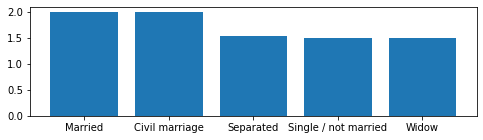

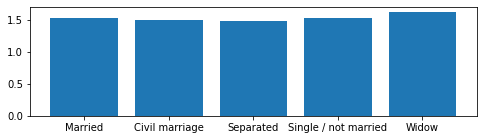

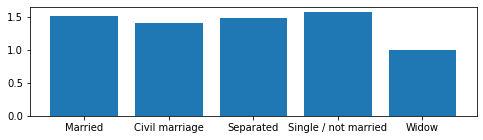

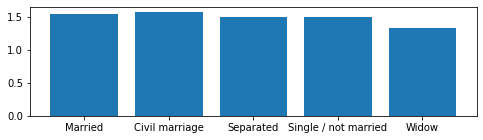

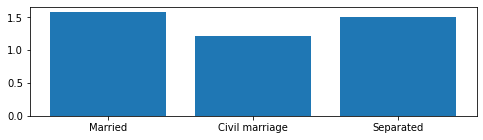

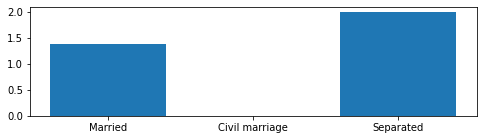

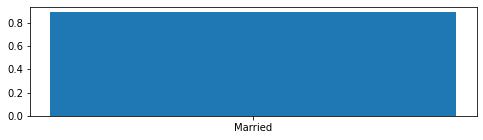

In [187]:
for i in range(1,8):
    f = family[family['family_size'] == i]
    m = []
    for j in family_type:
        ff = f[f['family_type'] == j]
        m.append(ff['credit'].mean())
        
    plt.figure(figsize = (8,2))
    plt.bar(family_type, m)

In [201]:
# float to int
toint_cols = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'credit']
train[toint_cols] = train[toint_cols].astype(int)

# int to object
toobj_cols = ['gender', 'car', 'reality', 'work_phone', 'phone', 'email']
train[toobj_cols] = train[toobj_cols].astype(object)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26450
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          26451 non-null  int64 
 1   gender         26451 non-null  object
 2   car            26451 non-null  object
 3   reality        26451 non-null  object
 4   child_num      26451 non-null  int64 
 5   income_total   26451 non-null  int32 
 6   income_type    26451 non-null  object
 7   edu_type       26451 non-null  object
 8   family_type    26451 non-null  object
 9   house_type     26451 non-null  object
 10  DAYS_BIRTH     26451 non-null  int32 
 11  DAYS_EMPLOYED  26451 non-null  int32 
 12  work_phone     26451 non-null  object
 13  phone          26451 non-null  object
 14  email          26451 non-null  object
 15  occyp_type     26451 non-null  object
 16  family_size    26451 non-null  int32 
 17  begin_month    26451 non-null  int32 
 18  credit         26451 non-n

### family_type 을 Married 와 Unmarried 로만 나누었을 때

In [202]:
train2 = train
train2['family_type'] = train2['family_type'].map(lambda x: 'Married' 
                                                if (x == 'Married' or x == 'Civil marriage')
                                                else 'Not Married')
train2.drop(['child_num'], axis = 1, inplace= True)

In [203]:
train2

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,202500,Commercial associate,Higher education,Married,Municipal apartment,38,157,0,0,0,N,2,6,1
1,1,F,N,Y,247500,Commercial associate,Secondary / secondary special,Married,House / apartment,31,51,0,0,1,Laborers,3,5,1
2,2,M,Y,Y,450000,Working,Higher education,Married,House / apartment,52,147,0,1,0,Managers,2,22,2
3,3,F,N,Y,202500,Commercial associate,Secondary / secondary special,Married,House / apartment,41,69,0,1,0,Sales staff,2,37,0
4,4,F,Y,Y,157500,State servant,Higher education,Married,House / apartment,41,70,0,0,0,Managers,2,26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,26452,F,N,N,225000,State servant,Secondary / secondary special,Married,House / apartment,33,66,0,0,0,Core staff,4,2,1
26447,26453,F,N,Y,180000,Working,Higher education,Not Married,House / apartment,41,82,0,0,0,N,2,47,2
26448,26454,F,Y,N,292500,Working,Secondary / secondary special,Married,With parents,27,67,0,0,0,Core staff,2,25,2
26449,26455,M,N,Y,171000,Working,Incomplete higher,Not Married,House / apartment,27,3,0,0,0,Laborers,1,59,2


In [211]:
X = train2.drop('credit', axis=1)
y = train2['credit']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [212]:
cat_cols = train.columns[train.dtypes == 'object'].to_list()

train_pool = Pool(X_train, y_train, cat_features = cat_cols)
eval_pool = Pool(X_val, y_val, cat_features = cat_cols)

In [213]:
model = CatBoostClassifier() 
model.fit(train_pool, eval_set=eval_pool,early_stopping_rounds=100, verbose=100) 

Learning rate set to 0.114773
0:	learn: 1.0350128	test: 1.0332529	best: 1.0332529 (0)	total: 68ms	remaining: 1m 7s
100:	learn: 0.7903263	test: 0.7909372	best: 0.7909372 (100)	total: 8.63s	remaining: 1m 16s
200:	learn: 0.7593554	test: 0.7815246	best: 0.7815183 (199)	total: 20.8s	remaining: 1m 22s
300:	learn: 0.7332467	test: 0.7753274	best: 0.7753274 (300)	total: 31.7s	remaining: 1m 13s
400:	learn: 0.7090980	test: 0.7700471	best: 0.7699385 (398)	total: 42.1s	remaining: 1m 2s
500:	learn: 0.6872812	test: 0.7679687	best: 0.7679687 (500)	total: 52s	remaining: 51.8s
600:	learn: 0.6667465	test: 0.7647859	best: 0.7647595 (594)	total: 1m 1s	remaining: 40.8s
700:	learn: 0.6458270	test: 0.7624125	best: 0.7621896 (692)	total: 1m 10s	remaining: 30s
800:	learn: 0.6275841	test: 0.7614161	best: 0.7612910 (797)	total: 1m 19s	remaining: 19.6s
900:	learn: 0.6092547	test: 0.7603493	best: 0.7603430 (899)	total: 1m 28s	remaining: 9.74s
999:	learn: 0.5939491	test: 0.7599864	best: 0.7597482 (970)	total: 1m 38s

In [214]:
pred_train = model.predict_proba(X_train)
pred_val = model.predict_proba(X_val)

In [215]:
print(f'\tLog Loss: {log_loss(y_val, pred_val):.6f}')

	Log Loss: 0.759748


In [216]:
print('~~~ {:.4}'.format(accuracy_score(y_val, model.predict(X_val))))

~~~ 0.7103


### child_num만 제거했을 때

In [220]:
train3 = train
train3

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,202500,Commercial associate,Higher education,Married,Municipal apartment,38,157,0,0,0,N,2,6,1
1,1,F,N,Y,247500,Commercial associate,Secondary / secondary special,Married,House / apartment,31,51,0,0,1,Laborers,3,5,1
2,2,M,Y,Y,450000,Working,Higher education,Married,House / apartment,52,147,0,1,0,Managers,2,22,2
3,3,F,N,Y,202500,Commercial associate,Secondary / secondary special,Married,House / apartment,41,69,0,1,0,Sales staff,2,37,0
4,4,F,Y,Y,157500,State servant,Higher education,Married,House / apartment,41,70,0,0,0,Managers,2,26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,26452,F,N,N,225000,State servant,Secondary / secondary special,Married,House / apartment,33,66,0,0,0,Core staff,4,2,1
26447,26453,F,N,Y,180000,Working,Higher education,Not Married,House / apartment,41,82,0,0,0,N,2,47,2
26448,26454,F,Y,N,292500,Working,Secondary / secondary special,Married,With parents,27,67,0,0,0,Core staff,2,25,2
26449,26455,M,N,Y,171000,Working,Incomplete higher,Not Married,House / apartment,27,3,0,0,0,Laborers,1,59,2


In [221]:
X = train3.drop('credit', axis=1)
y = train3['credit']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [223]:
cat_cols = train.columns[train.dtypes == 'object'].to_list()

train_pool = Pool(X_train, y_train, cat_features = cat_cols)
eval_pool = Pool(X_val, y_val, cat_features = cat_cols)

In [224]:
model = CatBoostClassifier() 
model.fit(train_pool, eval_set=eval_pool,early_stopping_rounds=100, verbose=100) 

Learning rate set to 0.114773
0:	learn: 1.0350128	test: 1.0332529	best: 1.0332529 (0)	total: 70.9ms	remaining: 1m 10s
100:	learn: 0.7903263	test: 0.7909372	best: 0.7909372 (100)	total: 7.23s	remaining: 1m 4s
200:	learn: 0.7593554	test: 0.7815246	best: 0.7815183 (199)	total: 16.5s	remaining: 1m 5s
300:	learn: 0.7332467	test: 0.7753274	best: 0.7753274 (300)	total: 25.6s	remaining: 59.4s
400:	learn: 0.7090980	test: 0.7700471	best: 0.7699385 (398)	total: 37.6s	remaining: 56.2s
500:	learn: 0.6872812	test: 0.7679687	best: 0.7679687 (500)	total: 50.1s	remaining: 49.9s
600:	learn: 0.6667465	test: 0.7647859	best: 0.7647595 (594)	total: 1m	remaining: 40.5s
700:	learn: 0.6458270	test: 0.7624125	best: 0.7621896 (692)	total: 1m 12s	remaining: 31s
800:	learn: 0.6275841	test: 0.7614161	best: 0.7612910 (797)	total: 1m 27s	remaining: 21.8s
900:	learn: 0.6092547	test: 0.7603493	best: 0.7603430 (899)	total: 1m 45s	remaining: 11.6s
999:	learn: 0.5939491	test: 0.7599864	best: 0.7597482 (970)	total: 1m 58s	

In [225]:
pred_train = model.predict_proba(X_train)
pred_val = model.predict_proba(X_val)

In [226]:
from sklearn.metrics import log_loss
print(f'\tLog Loss: {log_loss(y_val, pred_val):.6f}')

	Log Loss: 0.759748


In [227]:
from sklearn.metrics import accuracy_score
print('~~~ {:.4}'.format(accuracy_score(y_val, model.predict(X_val))))

~~~ 0.7103
